In [58]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [59]:
def read_data(csv):
    df = pd.read_csv(csv, thousands=',', skipinitialspace=True)
    
    print("Columns found in CSV:", df.columns.tolist())
    
    df['Date'] = pd.to_datetime(df['Date'])
    
    # remove $ and make it into float
    price_columns = ['Close/Last', 'Open', 'High', 'Low']
    for col in price_columns:
        df[col] = df[col].str.replace('$', '').astype(float)

    df.set_index('Date', inplace=True)
  
    df = df.rename(columns={'Close/Last': 'Close'})
    
    return df

In [60]:
def train_test_split(df, test_size=0.2):
    """
    Split the data into training and testing sets
    """
    split_idx = int(len(df) * (1 - test_size))
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    return train, test

In [61]:
def plot_train_test(train, test, predictions):
    plt.figure(figsize=(12, 6))
    
    # Plot training data
    plt.plot(train.index, train['Close'], label='Training Data', color='blue', linewidth=1)
    
    # Plot testing data
    plt.plot(test.index, test['Close'], label='Testing Data', color='orange', linewidth=1)
    
    # Plot predictions
    plt.plot(test.index, predictions, label='Predictions', color='red', linestyle='--', linewidth=2)
    
    plt.title('Train-Test Split with Model Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [62]:
def plot_comprehensive_analysis(df):
   
    plt.style.use('ggplot')  
    fig = plt.figure(figsize=(15, 12))
    
    # 1. Price and Volume Plot
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax1.plot(df.index, df['Close'], label='Close Price', color='blue', linewidth=1)
    ax1.set_title('Stock Price Over Time')
    ax1.set_ylabel('Price ($)')
    ax1.grid(True)
  
    ax1v = ax1.twinx()
    ax1v.bar(df.index, df['Volume'], alpha=0.3, color='gray', label='Volume')
    ax1v.set_ylabel('Volume')
 
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1v.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # 2. Candlestick-like Daily Range
    ax2 = plt.subplot2grid((3, 2), (1, 0))
    df['Daily_Range'] = df['High'] - df['Low']
    ax2.fill_between(df.index, df['High'], df['Low'], alpha=0.3, color='green')
    ax2.plot(df.index, df['Close'], color='blue', linewidth=1)
    ax2.set_title('Daily Price Range')
    ax2.set_ylabel('Price ($)')
    ax2.grid(True)
    
    # 3. Volume Distribution
    ax3 = plt.subplot2grid((3, 2), (1, 1))
    ax3.hist(df['Volume'], bins=50, color='gray')
    ax3.set_title('Volume Distribution')
    ax3.set_xlabel('Volume')
    
    # 4. Daily Returns
    ax4 = plt.subplot2grid((3, 2), (2, 0))
    daily_returns = df['Close'].pct_change() * 100
    ax4.plot(df.index, daily_returns, color='purple', linewidth=1)
    ax4.set_title('Daily Returns (%)')
    ax4.set_ylabel('Returns (%)')
    ax4.grid(True)
    
    # 5. Returns Distribution
    ax5 = plt.subplot2grid((3, 2), (2, 1))
    ax5.hist(daily_returns.dropna(), bins=50, color='purple')
    ax5.set_title('Returns Distribution')
    ax5.set_xlabel('Returns (%)')
    
    plt.tight_layout()
    plt.show()

In [63]:
def check_stationarity(timeseries):
    # ADF Test for getting stationarity and if not differencing to be performed
    result = adfuller(timeseries)
    print('Augmented Dickey-Fuller Test:')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    # Stationarity plots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
    
    # Original Price
    ax1.plot(timeseries)
    ax1.set_title('Original Price Series')
    ax1.grid(True)
    
    # Rolling Statistics
    rolling_mean = timeseries.rolling(window=30).mean()
    rolling_std = timeseries.rolling(window=30).std()
    ax2.plot(timeseries, label='Original', alpha=0.5)
    ax2.plot(rolling_mean, label='30-day Rolling Mean', color='red')
    ax2.plot(rolling_std, label='30-day Rolling Std', color='green')
    ax2.set_title('Rolling Statistics')
    ax2.grid(True)
    ax2.legend()
    
    # First Difference
    ax3.plot(timeseries.diff().dropna())
    ax3.set_title('First Difference')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return result[1] < 0.05

In [64]:
def plot_forecast_results(original_data, predictions, forecast):
    plt.figure(figsize=(12, 6))
    
    # Plot original data
    plt.plot(original_data.index, original_data, label='Historical Data', color='blue', linewidth=1)
    
    # Plot fitted values
    plt.plot(predictions.index, predictions, label='Fitted Values', color='red', alpha=0.7, linewidth=1)
    
    # Plot forecast
    forecast_index = pd.date_range(start=original_data.index[-1], periods=len(forecast)+1, closed='right')
    plt.plot(forecast_index, forecast, label='Forecast', color='green', linewidth=2)
    
    plt.title('Stock Price Forecast using ARIMA')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

Reading data from CSV...
Columns found in CSV: ['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low']

Successfully loaded data!
Date range: 2010-03-01 00:00:00 to 2020-02-28 00:00:00

Generating analysis plots...


C:\Users\Sanika\AppData\Local\Temp\ipykernel_1488\2823469468.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


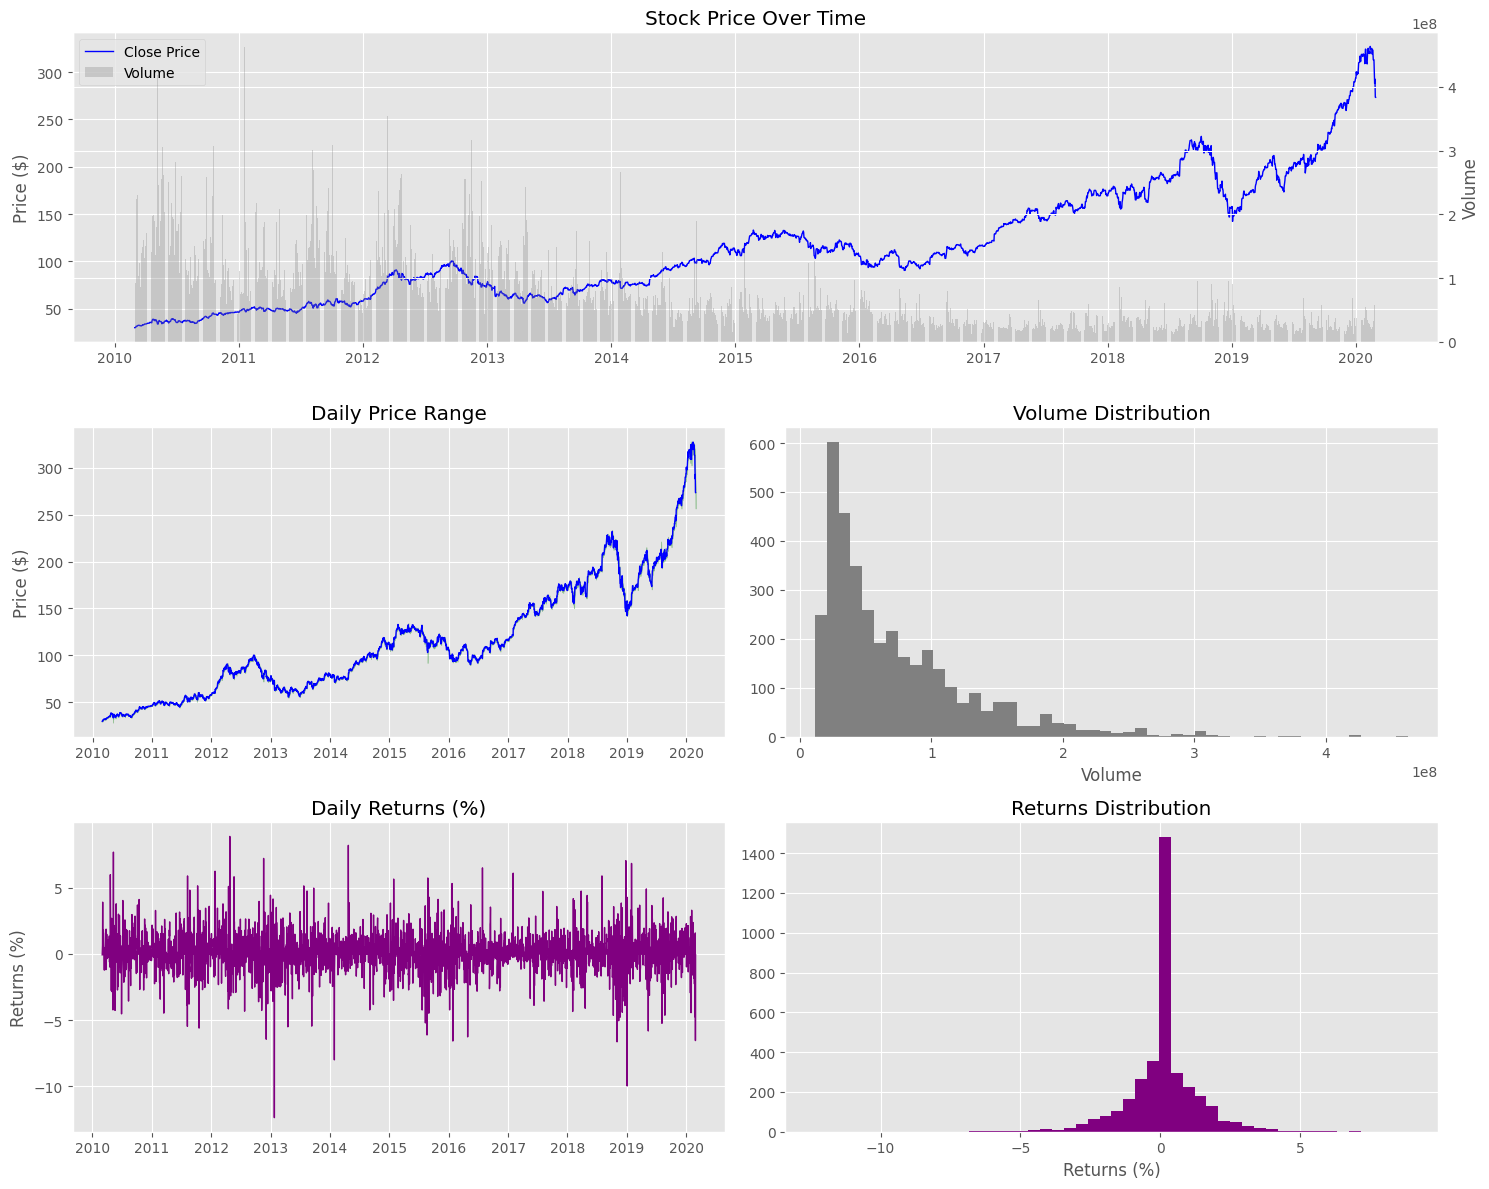


Checking stationarity...
Augmented Dickey-Fuller Test:
ADF Statistic: -0.5160492460038131
p-value: 0.8888463592762033
Critical values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


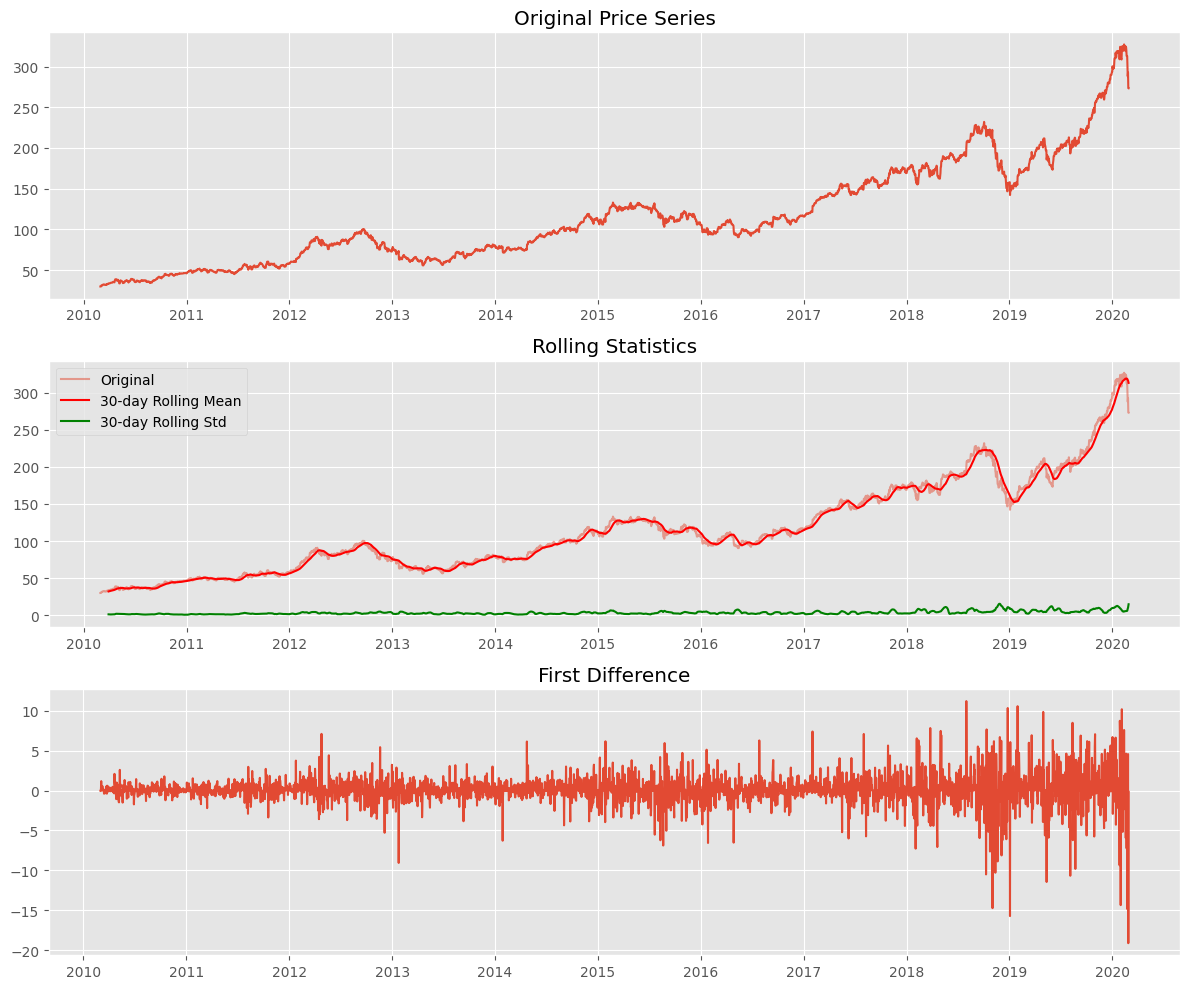


Splitting data into train and test sets...

Training ARIMA model...


c:\Users\Sanika\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Sanika\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


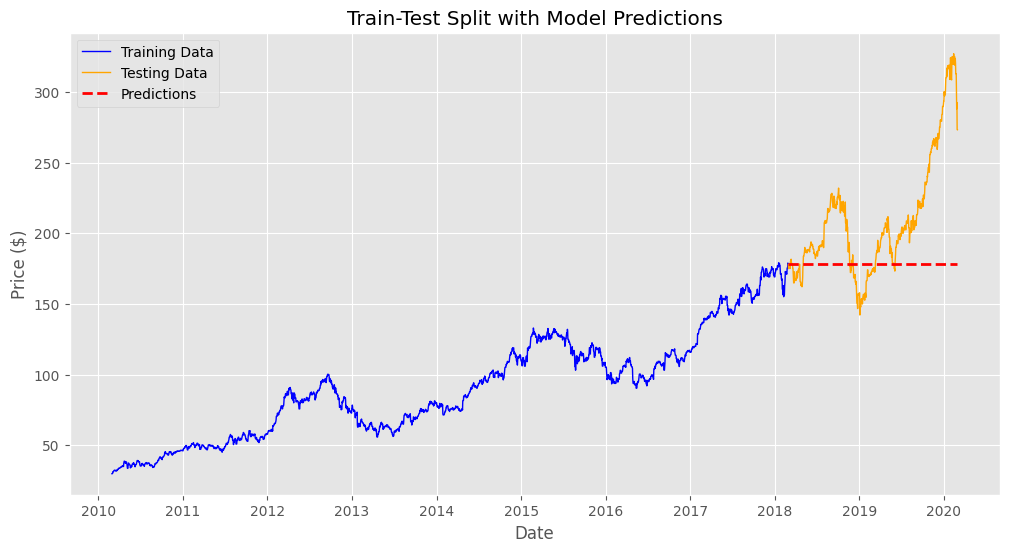


Model RMSE: $52.59

Generating forecast plot...

Error: DatetimeArray._generate_range() got an unexpected keyword argument 'closed'
Please ensure your CSV file is in the correct format:
Date, Close/Last, Volume, Open, High, Low
Example: 02/28/2020, $273.36, 106721200, $257.26, $278.41, $256.37


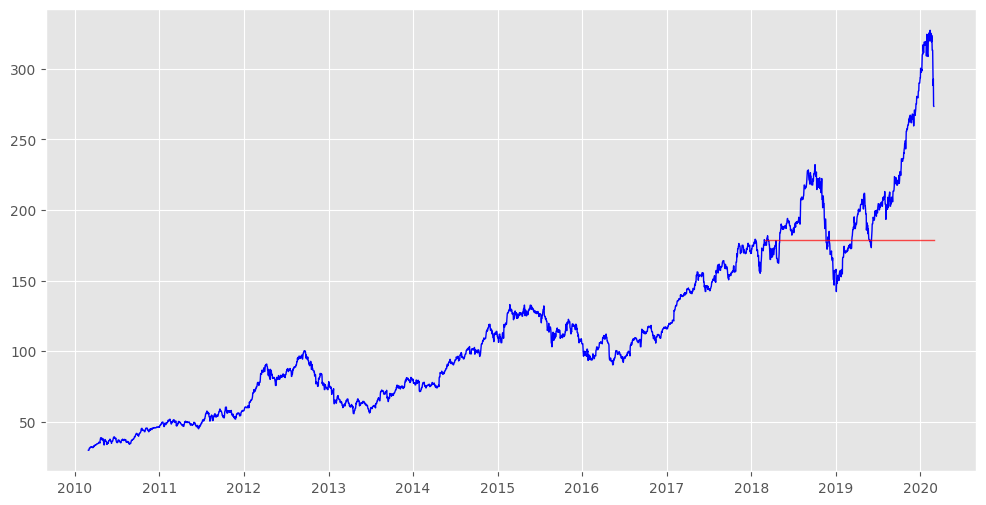

In [68]:
def main():
    # Parameters
    csv = 'HistoricalQuotes.csv'
    forecast_days = 30

    try:
        print("Reading data from CSV...")
        df = read_data(csv)
        # Ensure the data has a daily frequency and is sorted by date
        df = df.asfreq('D').sort_index()

        # Check for missing dates and handle them (forward fill missing data)
        df = df.fillna(method='ffill')
        print("\nSuccessfully loaded data!")
        print(f"Date range: {df.index.min()} to {df.index.max()}")
        
        print("\nGenerating analysis plots...")
        plot_comprehensive_analysis(df)

        print("\nChecking stationarity...")
        is_stationary = check_stationarity(df['Close'])

        print("\nSplitting data into train and test sets...")
        train, test = train_test_split(df)

        print("\nTraining ARIMA model...")
        # Using ARIMA(1,1,1) since we confirmed non-stationarity
        model = ARIMA(train['Close'], order=(1,1,1))
        results = model.fit()
        
        # Make predictions on the test set, using the correct start and end index
        predictions = results.get_prediction(start=test.index[0], end=test.index[-1]).predicted_mean
        
        # Plot train-test values
        plot_train_test(train, test, predictions)

        # Make forecast
        forecast = results.forecast(steps=forecast_days)
  
        mse = mean_squared_error(test['Close'], predictions)
        rmse = np.sqrt(mse)
        print(f"\nModel RMSE: ${rmse:.2f}")

        print("\nGenerating forecast plot...")
        plot_forecast_results(df['Close'], predictions, forecast)

        print("\nForecast for the next 7 days:")
        next_week = forecast[:7]
        for date, price in zip(pd.date_range(start=df.index[-1], periods=8, closed='right')[:7], next_week):
            print(f"{date.strftime('%Y-%m-%d')}: ${price:.2f}")
        
    except Exception as e:
        print(f"\nError: {str(e)}")
        print("Please ensure your CSV file is in the correct format:")
        print("Date, Close/Last, Volume, Open, High, Low")
        print("Example: 02/28/2020, $273.36, 106721200, $257.26, $278.41, $256.37")

if __name__ == "__main__":
    main()
